In [8]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_turned_off=True, only_standard_refuelling=True)

# Without adding historical data

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class FurnaceModelTrainer:
    def __init__(self, df, input_columns, slice_step=1, cross_validation_splitter=TimeSeriesSplit(n_splits=5), cross_validation_params=None, model_builder=lambda: LinearRegression()):
        self.df = df
        self.slice_step = slice_step
        self.input_columns = input_columns
        self.cross_validation_splitter = cross_validation_splitter
        self.cross_validation_params = cross_validation_params
        if self.cross_validation_params is None:
            self.cross_validation_params = {}
        self.model_builder = model_builder
        
        self.X, self.y = split_xy(self.df, self.input_columns)
        self.model = None
        self.cross_validation_models = None
        
        
    def cross_validation(self):
        mape_scores = []
        mse_scores = []
        self.cross_validation_models = []
        for train_index, test_index in self.cross_validation_splitter.split(self.X, **self.cross_validation_params):
            train_index = train_index[::self.slice_step]
            test_index = test_index[::self.slice_step]
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            data_train, data_test = self.df.iloc[train_index], self.df.iloc[test_index]

            model = self.model_builder()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            mape_scores.append(mape)
            mse_scores.append(mse)
            self.cross_validation_models.append((model, X_train, X_test, y_train, y_test, data_train, data_test))
            
            print(f"Statistics for this fold: {mape}, {mse}, {np.sqrt(mse)}")
            
        avg_mape = np.mean(mape_scores)
        avg_mse = np.mean(mse_scores)
        
        print(f"Average MAPE: {avg_mape}")
        print(f"Average MSE: {avg_mse}")
        print(f"Average RSME: {np.sqrt(avg_mse)}")
        
    def train(self):
        self.model = self.model_builder()
        self.model.fit(self.X, self.y)
        
        return self.model
    
    def split_data(self, n=-1):
        model, X_train, X_test, y_train, y_test, data_train, data_test = self.cross_validation_models[n]
        
        y_pred = model.predict(X_test)
        
        return model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred
    
    def visualize_split_scatter(self, n=-1):
        model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred = self.split_data(n)
        sns.scatterplot(x=y_test, y=y_pred)
        plt.plot([0, 100], [0, 100], color='red', lw=3)
        
    def visualize_split_example(self, n=-1, days=5):
        model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred = self.split_data(n)
        
        start_date = data_test['date'].iloc[0]
        end_date = start_date + pd.Timedelta(days=days)
        
        print(start_date, end_date)

        # data for plot
        data_display = data_test.loc[(data_test['date'] >= start_date) & (data_test['date'] <= end_date)]
        y_pred_display = y_pred[:len(data_display)]

        sns.lineplot(x=data_display['date'], y=data_display['refuellingTimePointActual'], label='actual')
        sns.scatterplot(x=data_display['date'], y=y_pred_display, label='predicted', color='red')
        sns.scatterplot(x=data_display['date'], y=data_display['refuellingTimePoint'], label='Ofen Vorhersage', color='blue')
        
        # set figure size
        plt.gcf().set_size_inches(16, 8)
        
    def visualize_split(self, n=-1, days=5):
        plt.subplot(1, 2, 1)
        self.visualize_split_scatter(n)
        plt.subplot(1, 2, 2)
        self.visualize_split_example(n, days)
        
        

In [ ]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_15',
    'bufferChargingDegree', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    # 'Year sin', 'Year cos',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12'
]

In [66]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.ensemble import GradientBoostingRegressor

gradientBoostingTrainer = FurnaceModelTrainer(df, input_columns, slice_step=100, cross_validation_splitter=TimeSeriesSplit(n_splits=5), model_builder=lambda: GradientBoostingRegressor())
# gradientBoostingTrainer = FurnaceModelTrainer(df, input_columns, slice_step=100, cross_validation_splitter=GroupKFold(n_splits=5), cross_validation_params={'groups': df['refuellingDateActual']}, model_builder=lambda: GradientBoostingRegressor())

gradientBoostingTrainer.cross_validation()

Statistics for this fold: 0.7447846186408497, 79.66058476881109, 8.925277853871615
Statistics for this fold: 0.724877697749276, 85.04307672837984, 9.221880324986865
Statistics for this fold: 0.4723367446771349, 42.167436967198185, 6.493645891731253
Statistics for this fold: 0.4254086848376877, 85.94028135902661, 9.270398123005647
Statistics for this fold: 0.32543762346161087, 33.03255035721371, 5.747395093189062
Average MAPE: 0.5385690738733119
Average MSE: 65.16878603612588
Average RSME: 8.072718627335272


2022-11-23 07:45:00 2022-11-28 07:45:00


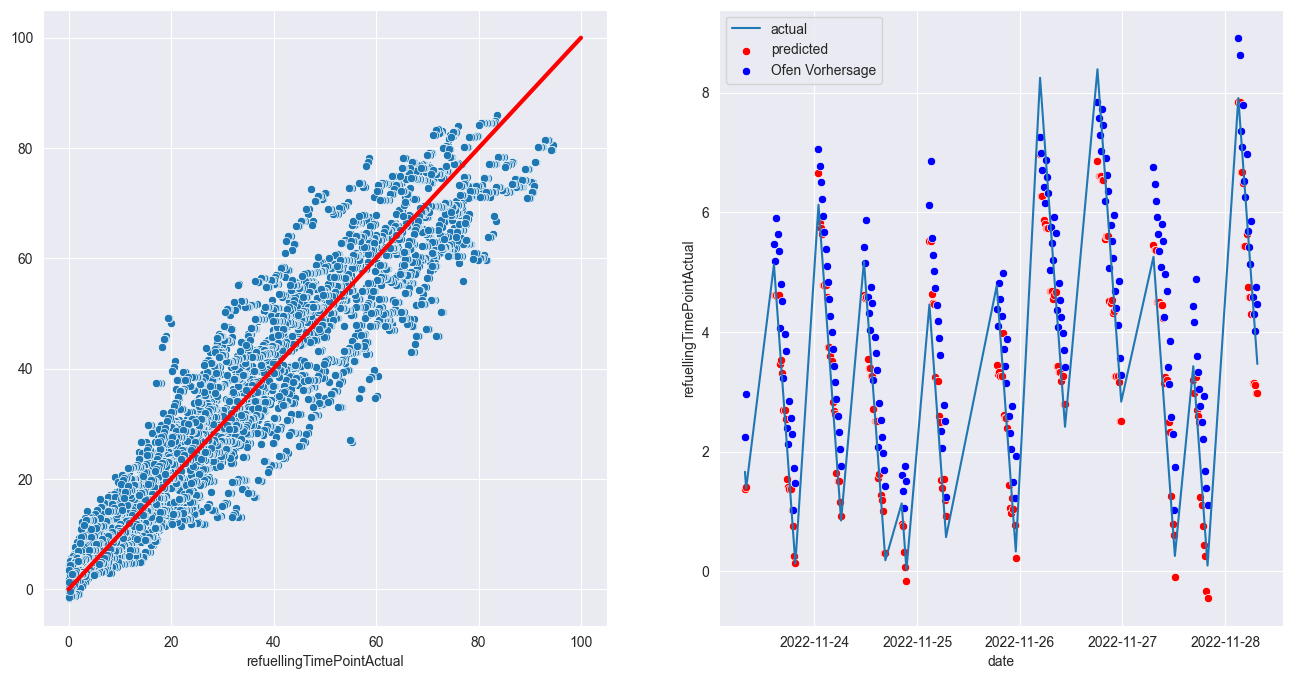

In [67]:
gradientBoostingTrainer.visualize_split()

In [62]:
# k nearest neighbors

from sklearn.neighbors import KNeighborsRegressor

knnTrainer = FurnaceModelTrainer(df, input_columns, slice_step=50, cross_validation_splitter=TimeSeriesSplit(n_splits=5), model_builder=lambda: KNeighborsRegressor(n_neighbors=5))
knnTrainer.cross_validation()

Statistics for this fold: 0.6487363887684539, 160.3802501791273, 12.664132428995178
Statistics for this fold: 0.6057353933889092, 228.7684516348116, 15.125093442184468
Statistics for this fold: 0.5402159868666279, 82.15376936573597, 9.063871654306231
Statistics for this fold: 0.44823283274319636, 260.8177740899283, 16.14985368633191
Statistics for this fold: 0.40730423048221165, 92.93103043134869, 9.640074192211836
Average MAPE: 0.5300449664498798
Average MSE: 165.0102551401904
Average RSME: 12.845631753253336


2022-11-23 07:45:00 2022-11-28 07:45:00


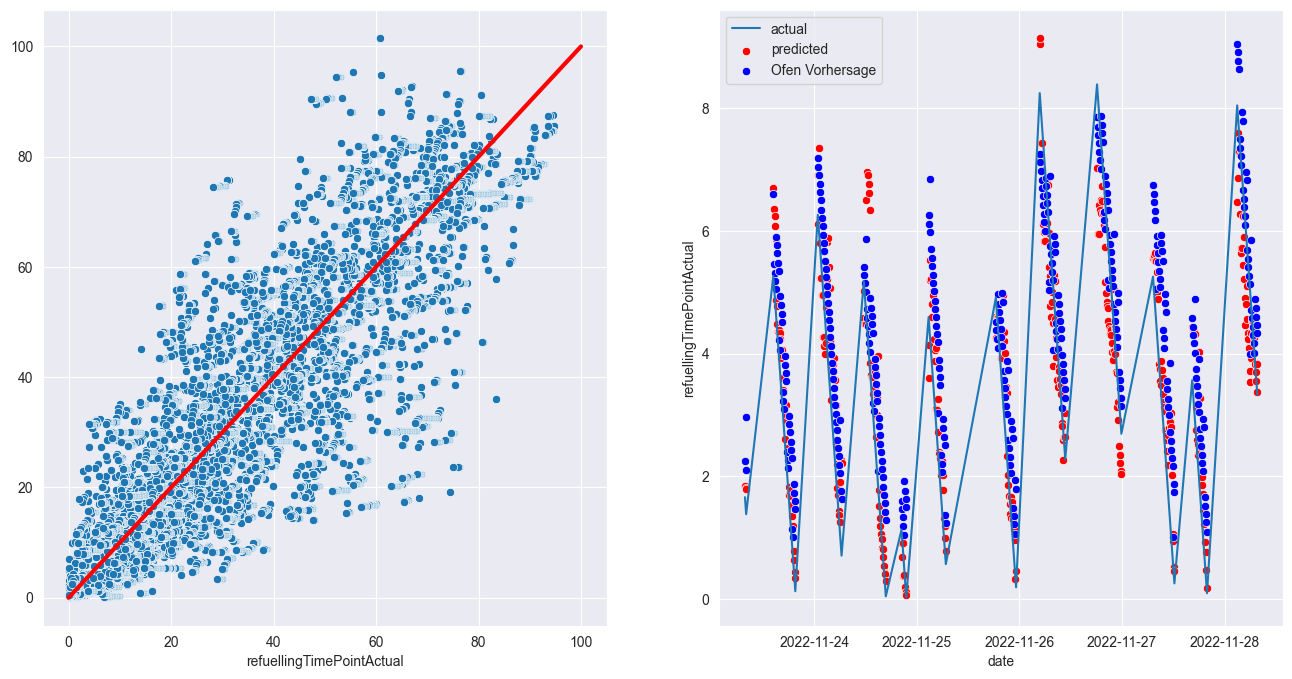

In [63]:
knnTrainer.visualize_split()

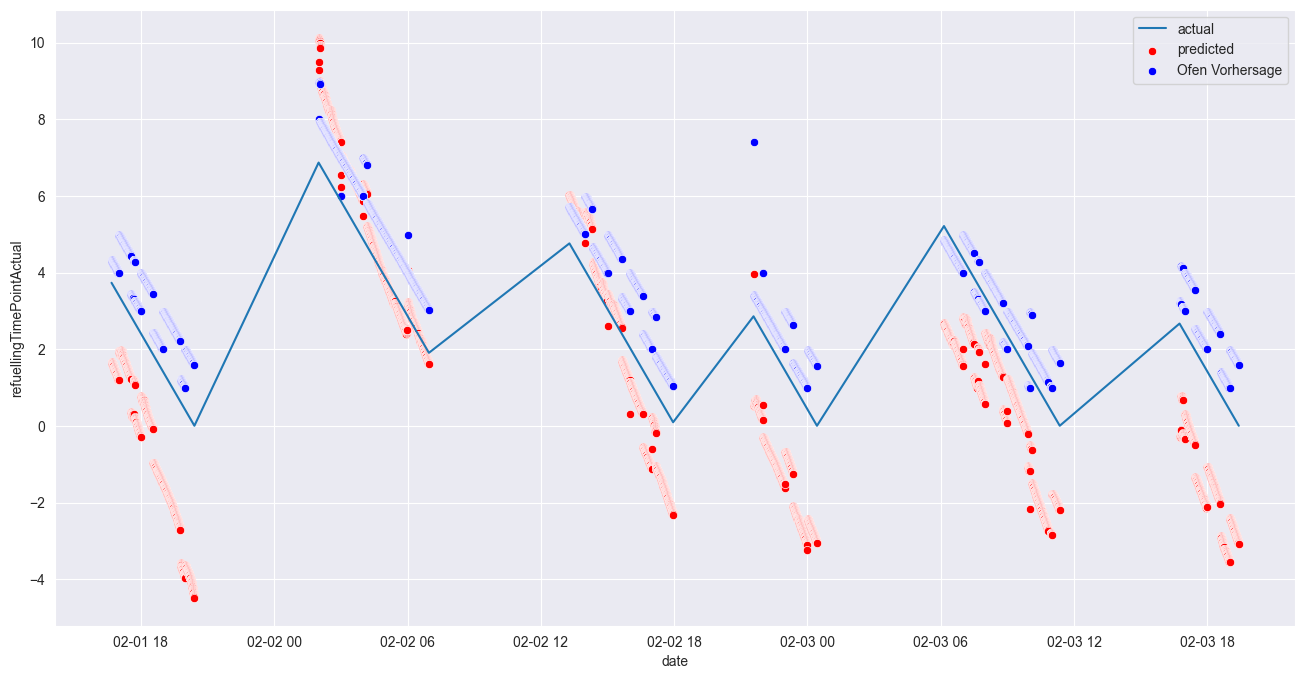

In [13]:
number_of_samples = 6 * 60 * 24

# data for plot
plot_data = df.iloc[-number_of_samples:]
plot_input = plot_data[input_columns]
plot_predicitions = model.predict(plot_input)

sns.lineplot(x=plot_data['date'], y=plot_data['refuellingTimePointActual'], label='actual')
sns.scatterplot(x=plot_data['date'], y=plot_predicitions, label='predicted', color='red')
sns.scatterplot(x=plot_data['date'], y=plot_data['refuellingTimePoint'], label='Ofen Vorhersage', color='blue')


# set figure size
plt.gcf().set_size_inches(16, 8)